### Sentiment Analysis of IMDB Movie Reviews

#### Problem Statement :
Given 50,000 reviews, our task is to predict whether the data gathered for testing would show positive or negative sentiment. 

We will keep some data for testing and use the rest for training.

#### Importing Libraries

In [4]:
import pandas as pd 
import numpy as np

import re
import string

import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud

import pickle

#### Importing dataset

In [5]:
path = 'Data/imdb_data.csv'
df = pd.read_csv(path)
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [6]:
df.shape

(50000, 2)

In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


#### Looking for any duplicate or missing values :

In [5]:
df.duplicated().sum()

418

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df.shape

(49582, 2)

#### Sentiment count :

In [9]:
df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

#### Lowercasing the original sentences :

In [9]:
df['review'] = df['review'].apply(lambda x: x.lower())
df['review'].sample()

39089    this movie is about three teens who have been ...
Name: review, dtype: object

#### Removing unwanted HTML tags :

In [10]:
def htmltags(txt):
    txt = re.sub(re.compile('<.*?>'), '', txt)
    return txt

In [11]:
df['review'].apply(htmltags)

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

#### Removing Stopwords :

In [12]:
sw = stopwords.words('english')
df['review'] = df['review'].apply(lambda x: [i for i in x.split() if i not in sw]).apply(lambda x: ' '.join(x))

df.sample()

,review,sentiment
43422,"like movies morally corrupt characters, much. ...",negative


#### Removing URLs :

In [13]:
def removeUrl(text):
    p =re.compile(r"https?://\S+|www\.\S+")
    return p.sub(r'', text)

df['review'] = df['review'].apply(removeUrl)

#### Removing Punctuations :

In [14]:
punc= string.punctuation
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def removePunc(text):
    return text.translate(str.maketrans('','', punc))

df['review'] = df['review'].apply(removePunc)

#### Lemmatization :

In [16]:
lemmatizer = WordNetLemmatizer()

def lem(txt):
    s = []
    sent = word_tokenize(txt)
    for word in sent:
        s.append(lemmatizer.lemmatize(word))

    return ' '.join(s)

In [19]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [17]:
df['review'] = df['review'].apply(lem)

#### Label Encoding :

In [21]:
en = LabelEncoder()
y = en.fit_transform(df['sentiment'])
y

array([1, 1, 1, ..., 0, 0, 0])

In [24]:
comment = []
for doc in df['review']:
    raw = sent_tokenize(doc)
    for sent in raw:
        comment.append(simple_preprocess(sent))

#### Converting Word into Vectors using Word2Vec algorithm :

In [25]:
model = gensim.models.Word2Vec(
    window = 10,
    min_count = 2
)

In [26]:
len(comment)

49582

In [27]:
model.build_vocab(comment)

In [28]:
model.train(comment, total_examples=model.corpus_count, epochs=model.epochs)

(28666106, 30851370)

#### Length of vocabulary (no. of words in vocabulary) :

In [29]:
len(model.wv.index_to_key)

70860

#### Average Word2Vec : 
We simply average each word of a document so that the generated document vector is actually a centroid of all words in feature space.

In [30]:
def document_vector(doc):
    new = [i for i in doc.split() if i in model.wv.index_to_key]
    return np.mean(model.wv[new], axis=0)

__Example :__

In [31]:
document_vector(df['review'].values[0])

array([ 0.62246203,  0.09984188,  0.04422702, -0.22960517, -0.0772144 ,
       -0.5070311 ,  0.8425616 ,  0.5891773 ,  0.04115144,  0.24194868,
        0.03238557, -0.11320531,  0.00557064,  0.01963594, -0.06383892,
       -0.0078267 , -0.1792575 ,  0.13221012, -0.11584643, -0.29176405,
       -0.33760226, -0.07981902, -0.29290378, -0.3863513 , -0.32592434,
        0.00689173,  0.08336066, -0.22146599,  0.29623184, -0.1229619 ,
        0.8419347 , -0.5328552 ,  0.29248852, -0.5249922 ,  0.45816648,
        0.42495805,  0.38128042,  0.14935799, -0.18571083, -0.3879461 ,
        0.07501417, -0.4529647 , -0.19089752,  0.08730777,  0.3032065 ,
       -0.55529606,  0.1484235 , -0.19394206,  0.18591803, -0.17241104,
        0.1692754 , -0.45281383, -0.24183159,  0.08929349, -0.18101156,
        0.10384404,  0.44697493,  0.01407371,  0.20089446, -0.2572593 ,
        0.12930632, -0.22554857, -0.39358962, -0.28974158, -0.3282461 ,
        0.21016835,  0.5591773 , -0.17272896, -0.2972311 ,  0.02

#### Creating Training Dataset :

In [32]:
X = []
for i in tqdm(df['review'].values):
    X.append(document_vector(i))
    
len(X)

100%|██████████| 49582/49582 [16:03<00:00, 51.44it/s]


49582

In [33]:
X = np.array(X)
X.shape

(49582, 100)

In [34]:
X[0]

array([ 0.62246203,  0.09984188,  0.04422702, -0.22960517, -0.0772144 ,
       -0.5070311 ,  0.8425616 ,  0.5891773 ,  0.04115144,  0.24194868,
        0.03238557, -0.11320531,  0.00557064,  0.01963594, -0.06383892,
       -0.0078267 , -0.1792575 ,  0.13221012, -0.11584643, -0.29176405,
       -0.33760226, -0.07981902, -0.29290378, -0.3863513 , -0.32592434,
        0.00689173,  0.08336066, -0.22146599,  0.29623184, -0.1229619 ,
        0.8419347 , -0.5328552 ,  0.29248852, -0.5249922 ,  0.45816648,
        0.42495805,  0.38128042,  0.14935799, -0.18571083, -0.3879461 ,
        0.07501417, -0.4529647 , -0.19089752,  0.08730777,  0.3032065 ,
       -0.55529606,  0.1484235 , -0.19394206,  0.18591803, -0.17241104,
        0.1692754 , -0.45281383, -0.24183159,  0.08929349, -0.18101156,
        0.10384404,  0.44697493,  0.01407371,  0.20089446, -0.2572593 ,
        0.12930632, -0.22554857, -0.39358962, -0.28974158, -0.3282461 ,
        0.21016835,  0.5591773 , -0.17272896, -0.2972311 ,  0.02

#### Spliting the dataset (80-20%) :

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [44]:
X_train.shape

(39665, 100)

#### Modelling 

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

__Accuracy of model on test data :__

In [46]:
score = accuracy_score(y_test, y_pred)

In [47]:
score

0.8370474942018755

__Plotting confusion matrix__

In [48]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)

<Axes: >

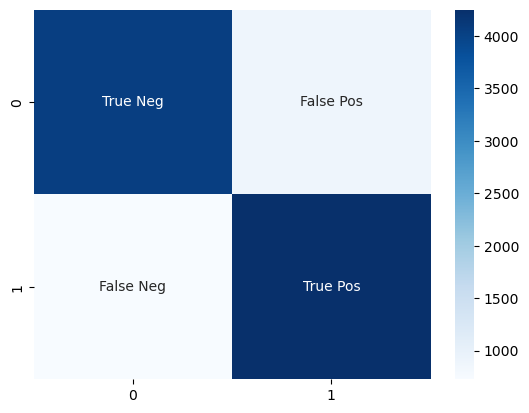

In [58]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

__Classification Report :__

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4940
           1       0.83      0.85      0.84      4977

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



#### Analysing the Sentiments using WordCloud :
__WordCloud for Positive Words.__ 

In [28]:
df['sentiment'].head(5)

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

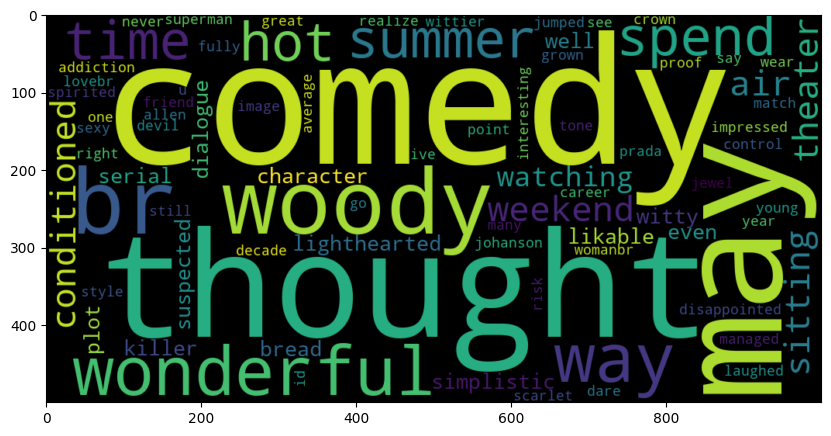

In [30]:
plt.figure(figsize=(10,10))
text=df["review"][2]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
words=WC.generate(text)
plt.imshow(words,interpolation='bilinear')
plt.show

__WordCloud for Negative Words.__ 

<function matplotlib.pyplot.show(close=None, block=None)>

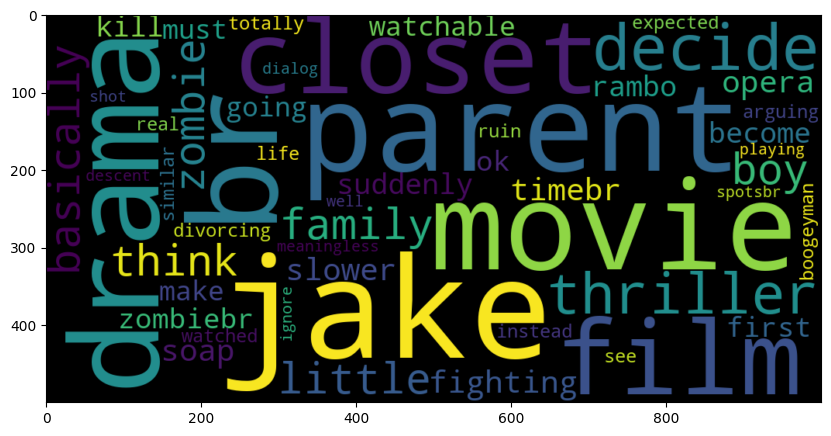

In [31]:
plt.figure(figsize=(10,10))
text=df["review"][3]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
words=WC.generate(text)
plt.imshow(words,interpolation='bilinear')
plt.show

__Saving The Model__

In [62]:
pickle.dump(model, open('rf.pkl', 'wb'))

#### Conclusion :

* We have observed that ensemble techniques work better on NLP projects compared to Naive Bayes or SVM.
* Model accuracy can further be improved by using lexicon models like Textblob.
* Such analysis are required by the companies/businesses to gain insights about how customers feel about certain topics, and detect urgent issues in real time before they spiral out of control.